# Multilingual embeddings

## Introduction

One of the applications of Embeddings is multilingual transfer learning.

Suppose you want to train an NLP model in several languages, but training data is only available in one of them. Collecting new training data for each of the target languages can be expensive, and translating all the texts you want to process even more so. However, with multilingual embeddings one can try to transfer a model from one language to another more efficiently.

## Goals

We will train a model to perform a sentiment analysis using an embedding architecture that we will make multilingual by replacing the weights for each specific language.to achieve this our embedding layer needs to project the words into a multilingual vector space

## Libraries and configuration

Next we will import the libraries that will be used throughout the notebook.

In [2]:
import os
import urllib

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from wordfreq import top_n_list

We will also configure some parameters to adapt the graphic presentation.

In [3]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

And create the necessary directories in case they have not been created previously

In [4]:
os.makedirs('tmp', exist_ok=True)

***

## Dataset

We are going to start directly from two embeddings extracted from the [FastText](https://github.com/facebookresearch/MUSE) library (belonging to [Facebook Research](https://research.fb.com/)).

This is a repository containing FastText embeddings trained with Wikipedia for more than 30 languages aligned in a single vector space. We are going to focus on English and German languages.

In [5]:
WIKI_EN = 'tmp/wiki.en.vec'
WIKI_DE = 'tmp/wiki.de.vec'

if not os.path.exists('tmp/wiki.en.vec'):
    print('Downloading english...', end='')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec', WIKI_EN)
    print('OK')
if not os.path.exists('tmp/wiki.de.vec'):
    print('Downloading german...', end='')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.de.vec', WIKI_DE)
    print('OK')

## Data preprocessing

As before, we will train a simple sentiment analysis model with the IMDb set.

After downloading the data, we will apply traditional preprocessing steps. We will work with a vocabulary of 10,000 words, cut long texts after 256 words and pad all shorter texts with padding.

In [6]:
VOCABULARY_SIZE = 10000
START_INDEX = 1
OOV_INDEX   = 2
INDEX_FROM  = 3
EMBEDDING_DIM = 300
SEQUENCE_LENGTH = 256

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    num_words=VOCABULARY_SIZE,  # Size for our vocabulary,
    start_char=START_INDEX,     # Start-of-sequence token index
    oov_char=OOV_INDEX,         # Out-of-vocabulary token index
    index_from=INDEX_FROM,      # Starting index for the actual words
)

x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train,
    padding='post',
    maxlen=SEQUENCE_LENGTH
)
x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test,
    padding='post',
    maxlen=SEQUENCE_LENGTH
)

### Pre-trained Embeddings

In order to be able to transfer our model between languages, our embedding layer needs to project the words into a multilingual vector space. Therefore, we are going to initialize our embedding layer with (a subset of) the downloaded word embeddings.

First, we need to figure out which words represent the indexes of the preprocessed IMDB data and then, we need to create an embedding where each row contains the word vector indexed by its row number. 

And we load the weights and words in their respective variables

In [7]:
def load_embedding(path):
    print(f'Loading vectors from {path}')
    embedding = []
    word_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            if i > 100000:
                break
            word, emb = line.rstrip().split(' ', 1)
            emb = np.fromstring(emb, sep=' ')
            embedding.append(emb)
            word_index[word] = len(word_index)

    embedding = np.vstack(embedding)
    return embedding, word_index

en_embedding, en_embedding_word_index = load_embedding(WIKI_EN)
de_embedding, de_embedding_word_index = load_embedding(WIKI_DE)

Loading vectors from tmp/wiki.en.vec
Loading vectors from tmp/wiki.de.vec


In [8]:


def create_embedding_matrix(target_word_index, embedding_word_index, embedding, rows, cols):
    embedding_matrix = np.zeros((rows, cols))
    for word, index in target_word_index.items():
        if index < rows and word in embedding_word_index: 
            embedding_matrix[index] = embedding[embedding_word_index[word]]
    return embedding_matrix

en_word_index = tf.keras.datasets.imdb.get_word_index()
en_word_index = {word: (index + INDEX_FROM) for word, index in en_word_index.items()}
en_word_index['<PAD>']   = 0
en_word_index['<START>'] = START_INDEX
en_word_index['<UNK>']   = OOV_INDEX

en_embedding_matrix = create_embedding_matrix(
    target_word_index=en_word_index,
    embedding_word_index=en_embedding_word_index,
    embedding=en_embedding,
    rows=VOCABULARY_SIZE + INDEX_FROM - 1,
    cols=EMBEDDING_DIM
)
en_embedding_matrix.shape

(10002, 300)

## Creating and training our model

Now it is time to create and train our model

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(
        input_dim=VOCABULARY_SIZE + INDEX_FROM - 1,
        output_dim=EMBEDDING_DIM,
        input_length=SEQUENCE_LENGTH,
        weights=[en_embedding_matrix],
        trainable=False
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 256, 300)          3000600   
                                                                 
 bidirectional (Bidirection  (None, 256, 128)          186880    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 3286425 (12.54 MB)
Trainable params: 285825 (1.09 MB)
Non-trainable params: 3000600 (11.45 MB)
_________________________________________________________________


We train the model.

In [14]:
history = model.fit(x_train, y_train, validation_split=0.1, epochs=10)

Epoch 1/10
704/704 [==============================] - 141s 197ms/step - loss: 0.5956 - binary_accuracy: 0.6817 - val_loss: 0.5530 - val_binary_accuracy: 0.7420
Epoch 2/10
704/704 [==============================] - 131s 187ms/step - loss: 0.4935 - binary_accuracy: 0.7652 - val_loss: 0.3943 - val_binary_accuracy: 0.8256
Epoch 3/10
704/704 [==============================] - 134s 190ms/step - loss: 0.4390 - binary_accuracy: 0.8063 - val_loss: 0.3693 - val_binary_accuracy: 0.8528
Epoch 4/10
704/704 [==============================] - 145s 205ms/step - loss: 0.3558 - binary_accuracy: 0.8504 - val_loss: 0.3331 - val_binary_accuracy: 0.8612
Epoch 5/10
704/704 [==============================] - 147s 209ms/step - loss: 0.3237 - binary_accuracy: 0.8669 - val_loss: 0.3146 - val_binary_accuracy: 0.8688
Epoch 6/10
704/704 [==============================] - 146s 207ms/step - loss: 0.2969 - binary_accuracy: 0.8760 - val_loss: 0.3147 - val_binary_accuracy: 0.8680
Epoch 7/10
704/704 [====================

And we check how the training has evolved.

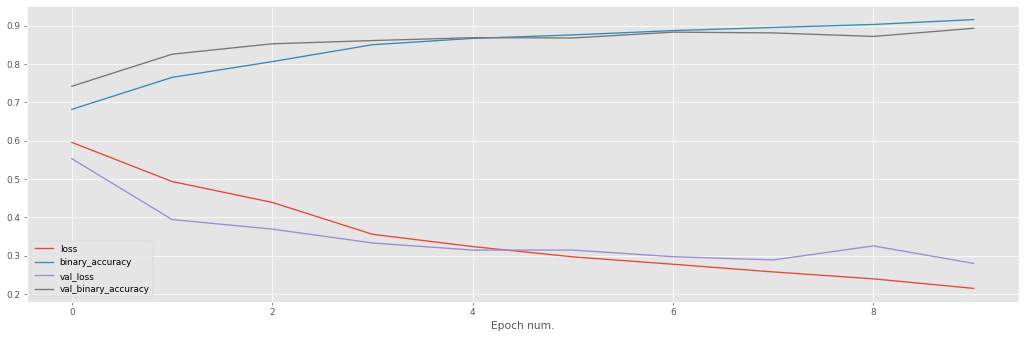

In [15]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Let's see if the model does what it is supposed to do.

In [16]:
comments = [
    'the movie was amazing'.split(),
    'i hated it'.split()
]
vectors = [
    [en_word_index.get(word, OOV_INDEX) for word in comment]
    for comment in comments
]
padded_vectors = tf.keras.preprocessing.sequence.pad_sequences(
    vectors,
    padding='post',
    maxlen=SEQUENCE_LENGTH
)

model.predict(padded_vectors)

1/1 [==============================] - 1s 651ms/step


array([[0.8127355 ],
       [0.23045711]], dtype=float32)

## Model transfer

Obviously, the above model cannot be used to classify texts written in German. To transfer our model from English to German, we have to replace its English embedding with a German one.

Again we are going to work with a vocabulary of 10,000 words. Unfortunately, we do not have a set of relevant German texts to embed the vocabulary in, so we will use the [wordfreq] library (https://github.com/LuminosoInsight/wordfreq). This contains word frequency information for many Western languages. In particular, `top_n_list` will give us the $n$ most frequent words in a language.

In [17]:
print(top_n_list('en', 10))
print(top_n_list('de', 10))

['the', 'to', 'and', 'of', 'a', 'in', 'i', 'is', 'for', 'that']
['die', 'der', 'und', 'in', 'das', 'ich', 'ist', 'nicht', 'zu', 'den']


We will build our vocabulary from the 10,000 most frequent German words and use it to create a German embedding.

In [18]:
de_word_index = {word: idx+INDEX_FROM for idx, word in enumerate(top_n_list('de', VOCABULARY_SIZE))}
de_word_index['<PAD>']   = 0
de_word_index['<START>'] = START_INDEX
de_word_index['<UNK>']   = OOV_INDEX

de_embedding_matrix = create_embedding_matrix(
    target_word_index=de_word_index,
    embedding_word_index=de_embedding_word_index,
    embedding=de_embedding,
    rows=VOCABULARY_SIZE + INDEX_FROM-1,
    cols=EMBEDDING_DIM
)
de_embedding_matrix.shape

(10002, 300)

Next, we will replace the weights of the original embedding (English) with the weights of the new embedding (German). To do this we must use the `set_weights([weight_matrix])` method of the `Embedding` class object.

In [19]:
model.layers[0].set_weights([de_embedding_matrix])

And as if by magic (weird magic) the model we just trained with English texts can now take German texts as input and classify them correctly.

In [20]:
comments = [
    'Ich fand den Film sehr gut'.split(),
    'Was für ein Chaos, ich wäre lieber zu Hause geblieben.'.split(),
    'Es war interessant, aber ich bevorzuge das Buch'.split(),
]
vectors        =  [
    [de_word_index.get(word, OOV_INDEX) for word in comment]
    for comment in comments
]
padded_vectors = tf.keras.preprocessing.sequence.pad_sequences(
    vectors,
    padding='post',
    maxlen=SEQUENCE_LENGTH
)
model.predict(padded_vectors)

1/1 [==============================] - 0s 35ms/step


array([[0.35910037],
       [0.12916137],
       [0.16145098]], dtype=float32)

## Conclusions

Multilingual _embeddings_ allow us to transfer a model from one language to another. It is very useful when you need to apply the same model to several languages and you only have data in one of them.

Of course, this is not without problems. The more different two languages are, the worse they will behave (we have just seen this with English and German, which are not exactly very different). Languages are not only words, but also expressions, word orders, etc. However, when two languages are linguistically similar (e.g. Spanish and Asturian), this solution is reasonably good.